[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=gpu,floatX=float32

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS=device=gpu,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomBasic-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

[2017-02-22 03:13:58,194] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace any calls to `register(timestep_limit=200)` with `register(tags={'wrapper_config.TimeLimit.max_episode_steps': 200)}`, . This change was made 12/28/2016 and is included in gym version 0.7.0. If you are getting many of these warnings, you may need to update universe past version 0.21.1
[2017-02-22 03:13:58,195] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace any calls to `register(timestep_limit=200)` with `register(tags={'wrapper_config.TimeLimit.max_episode_steps': 200)}`, . This change was made 12/28/2016 and is included in gym version 0.7.0. If you are getting many of these warnings, you may need to update universe past version 0.21.1
[2017-02-22 03:13:58,196] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace any calls to `register(timestep_limit=200)` with `register(tags={'wrapper_config.TimeLimit.max_episode_steps': 200)}`, . This ch

Couldn't import dot_parser, loading of dot files will not be possible.


ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
[2017-02-22 03:13:58,577] nvcc compiler not found on $PATH. Check your nvcc installation and try again.
[2017-02-22 03:13:58,615] Making new env: ppaquette/DoomBasic-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

-10.0 False


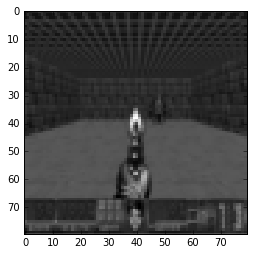

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print r, done
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=gpu0,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=gpu0,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=1000) #experience replay pool holding last 1k sessions


[2017-02-22 03:14:02,203] Making new env: ppaquette/DoomBasic-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[2 2 3 2 3 2 0]]
[[-5. -5. -5. -5. -5. -5.  0.]]
CPU times: user 228 ms, sys: 91.6 ms, total: 319 ms
Wall time: 139 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-02-22 03:14:37,215] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:14:37,234] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:14:37,236] Clearing 10 monitor files from previous run (because force=True was provided)
[2017-02-22 03:14:38,600] Starting new video recorder writing to /root/anet/agentnet/examples/records/openaigym.video.0.28576.video000000.mp4


Episode finished after 70 timesteps with reward=-440.0


[2017-02-22 03:14:40,715] Starting new video recorder writing to /root/anet/agentnet/examples/records/openaigym.video.0.28576.video000001.mp4


Episode finished after 70 timesteps with reward=-445.0
Episode finished after 70 timesteps with reward=-435.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 70 timesteps with reward=-445.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 3 timesteps with reward=86.0


[2017-02-22 03:14:47,006] Starting new video recorder writing to /root/anet/agentnet/examples/records/openaigym.video.0.28576.video000008.mp4


Episode finished after 70 timesteps with reward=-430.0
Episode finished after 70 timesteps with reward=-440.0


[2017-02-22 03:14:50,305] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')


Episode finished after 70 timesteps with reward=-440.0


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:untrained_reward}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  0%|          | 10/2000 [00:19<1:03:45,  1.92s/it]

iter=10	epsilon=0.954	reward/step=-2.33636


  1%|          | 20/2000 [00:38<1:02:45,  1.90s/it]

iter=20	epsilon=0.910	reward/step=-3.74762


  2%|▏         | 30/2000 [00:57<1:01:56,  1.89s/it]

iter=30	epsilon=0.868	reward/step=-3.92258


  2%|▏         | 40/2000 [01:16<1:05:38,  2.01s/it]

iter=40	epsilon=0.828	reward/step=-3.72683


  2%|▎         | 50/2000 [01:36<1:04:15,  1.98s/it]

iter=50	epsilon=0.790	reward/step=-3.97647


  3%|▎         | 60/2000 [01:56<1:04:14,  1.99s/it]

iter=60	epsilon=0.754	reward/step=-4.14426


  4%|▎         | 70/2000 [02:15<1:03:11,  1.96s/it]

iter=70	epsilon=0.719	reward/step=-4.12254


  4%|▍         | 80/2000 [02:34<1:01:45,  1.93s/it]

iter=80	epsilon=0.687	reward/step=-4.23086


  4%|▍         | 90/2000 [02:53<1:00:21,  1.90s/it]

iter=90	epsilon=0.656	reward/step=-4.20879


  5%|▍         | 99/2000 [03:10<57:13,  1.81s/it][2017-02-22 03:18:02,821] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:18:02,828] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:18:02,830] Clearing 8 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=-4.17228


[2017-02-22 03:18:05,288] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
  5%|▌         | 100/2000 [03:14<1:23:09,  2.63s/it]

Episode finished after 70 timesteps with reward=-400.0


  6%|▌         | 110/2000 [03:34<1:04:02,  2.03s/it]

iter=110	epsilon=0.598	reward/step=-4.07387


  6%|▌         | 120/2000 [03:53<1:00:10,  1.92s/it]

iter=120	epsilon=0.571	reward/step=-4.07107


  6%|▋         | 130/2000 [04:13<59:56,  1.92s/it]  

iter=130	epsilon=0.546	reward/step=-3.98779


  7%|▋         | 140/2000 [04:33<1:01:21,  1.98s/it]

iter=140	epsilon=0.522	reward/step=-3.99504


  8%|▊         | 150/2000 [04:52<1:01:45,  2.00s/it]

iter=150	epsilon=0.499	reward/step=-3.99801


  8%|▊         | 160/2000 [05:11<1:00:17,  1.97s/it]

iter=160	epsilon=0.477	reward/step=-3.93168


  8%|▊         | 170/2000 [05:31<59:00,  1.93s/it]

iter=170	epsilon=0.456	reward/step=-3.98538


  9%|▉         | 180/2000 [05:49<58:12,  1.92s/it]

iter=180	epsilon=0.436	reward/step=-3.92707


 10%|▉         | 190/2000 [06:09<58:12,  1.93s/it]

iter=190	epsilon=0.417	reward/step=-3.93822


 10%|▉         | 199/2000 [06:27<59:15,  1.97s/it]  [2017-02-22 03:21:20,217] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:21:20,225] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:21:20,226] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=-3.98358


[2017-02-22 03:21:21,364] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 10%|█         | 200/2000 [06:30<1:09:19,  2.31s/it]

Episode finished after 1 timesteps with reward=96.0


 10%|█         | 210/2000 [06:49<57:36,  1.93s/it]

iter=210	epsilon=0.382	reward/step=-4.03412


 11%|█         | 220/2000 [07:10<58:32,  1.97s/it]

iter=220	epsilon=0.366	reward/step=-4.07557


 12%|█▏        | 230/2000 [07:30<1:00:06,  2.04s/it]

iter=230	epsilon=0.351	reward/step=-4.06537


 12%|█▏        | 240/2000 [07:51<1:02:19,  2.12s/it]

iter=240	epsilon=0.336	reward/step=-4.05394


 12%|█▎        | 250/2000 [08:11<1:00:03,  2.06s/it]

iter=250	epsilon=0.322	reward/step=-4.07968


 13%|█▎        | 260/2000 [08:31<57:49,  1.99s/it]

iter=260	epsilon=0.309	reward/step=-4.06667


 14%|█▎        | 270/2000 [08:51<56:10,  1.95s/it]

iter=270	epsilon=0.296	reward/step=-3.97970


 14%|█▍        | 280/2000 [09:12<58:55,  2.06s/it]

iter=280	epsilon=0.284	reward/step=-3.86512


 14%|█▍        | 290/2000 [09:31<54:25,  1.91s/it]

iter=290	epsilon=0.273	reward/step=-3.85739


 15%|█▍        | 299/2000 [09:48<52:36,  1.86s/it][2017-02-22 03:24:41,190] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:24:41,197] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:24:41,198] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=-3.78804


[2017-02-22 03:24:43,898] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 15%|█▌        | 300/2000 [09:53<1:15:40,  2.67s/it]

Episode finished after 14 timesteps with reward=26.0


 16%|█▌        | 310/2000 [10:14<1:02:54,  2.23s/it]

iter=310	epsilon=0.252	reward/step=-3.78650


 16%|█▌        | 320/2000 [10:35<58:01,  2.07s/it]

iter=320	epsilon=0.242	reward/step=-3.81340


 16%|█▋        | 330/2000 [10:57<1:01:49,  2.22s/it]

iter=330	epsilon=0.232	reward/step=-3.84018


 17%|█▋        | 340/2000 [11:21<1:07:44,  2.45s/it]

iter=340	epsilon=0.224	reward/step=-3.80440


 18%|█▊        | 350/2000 [11:45<1:05:38,  2.39s/it]

iter=350	epsilon=0.215	reward/step=-3.82991


 18%|█▊        | 360/2000 [12:10<1:07:56,  2.49s/it]

iter=360	epsilon=0.207	reward/step=-3.85817


 18%|█▊        | 370/2000 [12:35<1:07:04,  2.47s/it]

iter=370	epsilon=0.199	reward/step=-3.76873


 19%|█▉        | 380/2000 [12:59<1:02:38,  2.32s/it]

iter=380	epsilon=0.192	reward/step=-3.76220


 20%|█▉        | 390/2000 [13:24<1:06:38,  2.48s/it]

iter=390	epsilon=0.185	reward/step=-3.72941


 20%|█▉        | 399/2000 [13:47<1:08:55,  2.58s/it][2017-02-22 03:28:40,253] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:28:40,261] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:28:40,262] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=-3.70075


[2017-02-22 03:28:41,423] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 20%|██        | 400/2000 [13:50<1:16:44,  2.88s/it]

Episode finished after 1 timesteps with reward=96.0


 20%|██        | 410/2000 [14:15<1:06:46,  2.52s/it]

iter=410	epsilon=0.172	reward/step=-3.72141


 21%|██        | 420/2000 [14:40<1:04:30,  2.45s/it]

iter=420	epsilon=0.166	reward/step=-3.74228


 22%|██▏       | 430/2000 [15:05<1:09:00,  2.64s/it]

iter=430	epsilon=0.161	reward/step=-3.76450


 22%|██▏       | 440/2000 [15:31<1:04:06,  2.47s/it]

iter=440	epsilon=0.155	reward/step=-3.61678


 22%|██▎       | 450/2000 [15:54<56:34,  2.19s/it]

iter=450	epsilon=0.150	reward/step=-3.58936


 23%|██▎       | 460/2000 [16:19<1:09:35,  2.71s/it]

iter=460	epsilon=0.145	reward/step=-3.56529


 24%|██▎       | 470/2000 [16:48<1:17:36,  3.04s/it]

iter=470	epsilon=0.141	reward/step=-3.58938


 24%|██▍       | 480/2000 [17:16<1:11:35,  2.83s/it]

iter=480	epsilon=0.136	reward/step=-3.60832


 24%|██▍       | 490/2000 [17:42<1:08:58,  2.74s/it]

iter=490	epsilon=0.132	reward/step=-3.56273


 25%|██▍       | 499/2000 [18:06<1:06:42,  2.67s/it][2017-02-22 03:33:00,488] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:33:00,495] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:33:00,497] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=-3.56108


[2017-02-22 03:33:01,798] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 25%|██▌       | 500/2000 [18:11<1:19:50,  3.19s/it]

Episode finished after 8 timesteps with reward=56.0


 26%|██▌       | 510/2000 [18:39<1:11:18,  2.87s/it]

iter=510	epsilon=0.124	reward/step=-3.56067


 26%|██▌       | 520/2000 [19:09<1:12:58,  2.96s/it]

iter=520	epsilon=0.121	reward/step=-3.58157


 26%|██▋       | 530/2000 [19:38<1:07:49,  2.77s/it]

iter=530	epsilon=0.117	reward/step=-3.59981


 27%|██▋       | 540/2000 [20:06<1:09:58,  2.88s/it]

iter=540	epsilon=0.114	reward/step=-3.51830


 28%|██▊       | 550/2000 [20:36<1:10:08,  2.90s/it]

iter=550	epsilon=0.111	reward/step=-3.47931


 28%|██▊       | 560/2000 [21:05<1:10:52,  2.95s/it]

iter=560	epsilon=0.108	reward/step=-3.46061


 28%|██▊       | 570/2000 [21:34<1:11:56,  3.02s/it]

iter=570	epsilon=0.105	reward/step=-3.46375


 29%|██▉       | 580/2000 [22:03<1:08:26,  2.89s/it]

iter=580	epsilon=0.102	reward/step=-3.44509


 30%|██▉       | 590/2000 [22:33<1:10:44,  3.01s/it]

iter=590	epsilon=0.100	reward/step=-3.44670


 30%|██▉       | 599/2000 [23:00<1:09:59,  3.00s/it][2017-02-22 03:37:53,836] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:37:53,844] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:37:53,845] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=-3.41381


[2017-02-22 03:37:55,304] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 30%|███       | 600/2000 [23:04<1:18:45,  3.38s/it]

Episode finished after 1 timesteps with reward=96.0


 30%|███       | 610/2000 [23:34<1:04:08,  2.77s/it]

iter=610	epsilon=0.095	reward/step=-3.36301


 31%|███       | 620/2000 [24:03<1:04:49,  2.82s/it]

iter=620	epsilon=0.093	reward/step=-3.27890


 32%|███▏      | 630/2000 [24:33<1:07:26,  2.95s/it]

iter=630	epsilon=0.091	reward/step=-3.26307


 32%|███▏      | 640/2000 [25:04<1:09:34,  3.07s/it]

iter=640	epsilon=0.089	reward/step=-3.26505


 32%|███▎      | 650/2000 [25:35<1:06:33,  2.96s/it]

iter=650	epsilon=0.087	reward/step=-3.20338


 33%|███▎      | 660/2000 [26:07<1:13:22,  3.29s/it]

iter=660	epsilon=0.085	reward/step=-3.19168


 34%|███▎      | 670/2000 [26:40<1:13:31,  3.32s/it]

iter=670	epsilon=0.083	reward/step=-3.19687


 34%|███▍      | 680/2000 [27:13<1:11:48,  3.26s/it]

iter=680	epsilon=0.082	reward/step=-3.15374


 34%|███▍      | 690/2000 [27:46<1:11:45,  3.29s/it]

iter=690	epsilon=0.080	reward/step=-3.03806


 35%|███▍      | 699/2000 [28:16<1:10:29,  3.25s/it][2017-02-22 03:43:10,243] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:43:10,250] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:43:10,251] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=-2.99914


[2017-02-22 03:43:11,537] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 35%|███▌      | 700/2000 [28:20<1:18:07,  3.61s/it]

Episode finished after 6 timesteps with reward=71.0


 36%|███▌      | 710/2000 [28:52<1:08:21,  3.18s/it]

iter=710	epsilon=0.077	reward/step=-2.82714


 36%|███▌      | 720/2000 [29:26<1:08:08,  3.19s/it]

iter=720	epsilon=0.076	reward/step=-2.77753


 36%|███▋      | 730/2000 [29:58<1:06:11,  3.13s/it]

iter=730	epsilon=0.075	reward/step=-2.71477


 37%|███▋      | 740/2000 [30:30<1:06:29,  3.17s/it]

iter=740	epsilon=0.073	reward/step=-2.66734


 38%|███▊      | 750/2000 [31:03<1:11:26,  3.43s/it]

iter=750	epsilon=0.072	reward/step=-2.66352


 38%|███▊      | 760/2000 [31:34<1:02:09,  3.01s/it]

iter=760	epsilon=0.071	reward/step=-2.64652


 38%|███▊      | 770/2000 [32:08<1:12:35,  3.54s/it]

iter=770	epsilon=0.070	reward/step=-2.67121


 39%|███▉      | 780/2000 [32:42<1:11:57,  3.54s/it]

iter=780	epsilon=0.069	reward/step=-2.68105


 40%|███▉      | 790/2000 [33:17<1:10:48,  3.51s/it]

iter=790	epsilon=0.068	reward/step=-2.69128


 40%|███▉      | 799/2000 [33:47<1:08:04,  3.40s/it][2017-02-22 03:48:41,849] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:48:41,856] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:48:41,858] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=-2.71323


[2017-02-22 03:48:43,835] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 40%|████      | 800/2000 [33:53<1:22:44,  4.14s/it]

Episode finished after 7 timesteps with reward=66.0


 40%|████      | 810/2000 [34:27<1:07:31,  3.40s/it]

iter=810	epsilon=0.067	reward/step=-2.68298


 41%|████      | 820/2000 [35:03<1:07:13,  3.42s/it]

iter=820	epsilon=0.066	reward/step=-2.64166


 42%|████▏     | 830/2000 [35:39<1:11:19,  3.66s/it]

iter=830	epsilon=0.065	reward/step=-2.66402


 42%|████▏     | 840/2000 [36:14<1:07:45,  3.50s/it]

iter=840	epsilon=0.064	reward/step=-2.63603


 42%|████▎     | 850/2000 [36:50<1:11:30,  3.73s/it]

iter=850	epsilon=0.064	reward/step=-2.58378


 43%|████▎     | 860/2000 [37:22<1:04:35,  3.40s/it]

iter=860	epsilon=0.063	reward/step=-2.59489


 44%|████▎     | 870/2000 [37:59<1:09:43,  3.70s/it]

iter=870	epsilon=0.062	reward/step=-2.56751


 44%|████▍     | 880/2000 [38:35<1:07:58,  3.64s/it]

iter=880	epsilon=0.062	reward/step=-2.55448


 44%|████▍     | 890/2000 [39:10<1:04:21,  3.48s/it]

iter=890	epsilon=0.061	reward/step=-2.54119


 45%|████▍     | 899/2000 [39:42<1:09:22,  3.78s/it][2017-02-22 03:54:36,991] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 03:54:36,999] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:54:37,000] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=-2.39767


[2017-02-22 03:54:38,173] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 45%|████▌     | 900/2000 [39:47<1:13:46,  4.02s/it]

Episode finished after 1 timesteps with reward=96.0


 46%|████▌     | 910/2000 [40:22<1:06:13,  3.65s/it]

iter=910	epsilon=0.060	reward/step=-2.25884


 46%|████▌     | 920/2000 [40:58<1:09:21,  3.85s/it]

iter=920	epsilon=0.060	reward/step=-2.28534


 46%|████▋     | 930/2000 [41:35<1:07:13,  3.77s/it]

iter=930	epsilon=0.059	reward/step=-2.20666


 47%|████▋     | 940/2000 [42:13<1:08:35,  3.88s/it]

iter=940	epsilon=0.059	reward/step=-2.18757


 48%|████▊     | 950/2000 [42:50<1:08:38,  3.92s/it]

iter=950	epsilon=0.058	reward/step=-2.21346


 48%|████▊     | 960/2000 [43:26<1:01:34,  3.55s/it]

iter=960	epsilon=0.058	reward/step=-2.19459


 48%|████▊     | 970/2000 [44:02<1:01:47,  3.60s/it]

iter=970	epsilon=0.057	reward/step=-2.15335


 49%|████▉     | 980/2000 [44:38<1:03:30,  3.74s/it]

iter=980	epsilon=0.057	reward/step=-2.06045


 50%|████▉     | 990/2000 [45:16<1:04:27,  3.83s/it]

iter=990	epsilon=0.057	reward/step=-2.04379


 50%|████▉     | 999/2000 [45:48<59:22,  3.56s/it]  [2017-02-22 04:00:43,375] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:00:43,383] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:00:43,384] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=-1.98160


[2017-02-22 04:00:45,450] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 50%|█████     | 1000/2000 [45:54<1:10:51,  4.25s/it]

Episode finished after 1 timesteps with reward=96.0


 50%|█████     | 1010/2000 [46:31<1:02:43,  3.80s/it]

iter=1010	epsilon=0.056	reward/step=-1.98620


 51%|█████     | 1020/2000 [47:10<1:02:36,  3.83s/it]

iter=1020	epsilon=0.056	reward/step=-1.80910


 52%|█████▏    | 1030/2000 [47:43<53:58,  3.34s/it]

iter=1030	epsilon=0.056	reward/step=-1.76930


 52%|█████▏    | 1040/2000 [48:23<57:39,  3.60s/it]  

iter=1040	epsilon=0.055	reward/step=-1.72150


 52%|█████▎    | 1050/2000 [49:02<1:02:30,  3.95s/it]

iter=1050	epsilon=0.055	reward/step=-1.69680


 53%|█████▎    | 1060/2000 [49:40<59:26,  3.79s/it]

iter=1060	epsilon=0.055	reward/step=-1.65140


 54%|█████▎    | 1070/2000 [50:18<57:49,  3.73s/it]

iter=1070	epsilon=0.055	reward/step=-1.57220


 54%|█████▍    | 1080/2000 [50:55<58:26,  3.81s/it]

iter=1080	epsilon=0.054	reward/step=-1.55860


 55%|█████▍    | 1090/2000 [51:34<1:00:47,  4.01s/it]

iter=1090	epsilon=0.054	reward/step=-1.40430


 55%|█████▍    | 1099/2000 [52:08<57:25,  3.82s/it][2017-02-22 04:07:02,877] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:07:02,884] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:07:02,886] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=-1.26300


[2017-02-22 04:07:05,835] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 55%|█████▌    | 1100/2000 [52:15<1:08:46,  4.59s/it]

Episode finished after 70 timesteps with reward=-269.0


 56%|█████▌    | 1110/2000 [52:52<55:53,  3.77s/it]

iter=1110	epsilon=0.054	reward/step=-1.11870


 56%|█████▌    | 1120/2000 [53:30<56:50,  3.88s/it]

iter=1120	epsilon=0.054	reward/step=-1.06010


 56%|█████▋    | 1130/2000 [54:08<55:49,  3.85s/it]

iter=1130	epsilon=0.053	reward/step=-1.04450


 57%|█████▋    | 1140/2000 [54:46<54:57,  3.83s/it]

iter=1140	epsilon=0.053	reward/step=-0.99700


 57%|█████▊    | 1150/2000 [55:23<53:11,  3.75s/it]

iter=1150	epsilon=0.053	reward/step=-0.96980


 58%|█████▊    | 1160/2000 [56:01<53:47,  3.84s/it]

iter=1160	epsilon=0.053	reward/step=-0.86970


 58%|█████▊    | 1170/2000 [56:38<49:36,  3.59s/it]

iter=1170	epsilon=0.053	reward/step=-0.79200


 59%|█████▉    | 1180/2000 [57:13<47:20,  3.46s/it]

iter=1180	epsilon=0.053	reward/step=-0.78600


 60%|█████▉    | 1190/2000 [57:51<49:46,  3.69s/it]

iter=1190	epsilon=0.052	reward/step=-0.73660


 60%|█████▉    | 1199/2000 [58:23<46:51,  3.51s/it][2017-02-22 04:13:17,705] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:13:17,713] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:13:17,715] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=-0.63770


[2017-02-22 04:13:23,629] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 60%|██████    | 1200/2000 [58:32<1:10:26,  5.28s/it]

Episode finished after 6 timesteps with reward=71.0


 60%|██████    | 1210/2000 [59:08<48:29,  3.68s/it]

iter=1210	epsilon=0.052	reward/step=-0.59120


 61%|██████    | 1220/2000 [59:44<44:49,  3.45s/it]

iter=1220	epsilon=0.052	reward/step=-0.57810


 62%|██████▏   | 1230/2000 [1:00:22<49:12,  3.83s/it]

iter=1230	epsilon=0.052	reward/step=-0.52260


 62%|██████▏   | 1240/2000 [1:00:55<42:31,  3.36s/it]

iter=1240	epsilon=0.052	reward/step=-0.44790


 62%|██████▎   | 1250/2000 [1:01:31<46:55,  3.75s/it]

iter=1250	epsilon=0.052	reward/step=-0.29750


 63%|██████▎   | 1260/2000 [1:02:07<40:32,  3.29s/it]

iter=1260	epsilon=0.052	reward/step=-0.18900


 64%|██████▎   | 1270/2000 [1:02:40<38:16,  3.15s/it]

iter=1270	epsilon=0.052	reward/step=-0.03720


 64%|██████▍   | 1280/2000 [1:03:16<44:40,  3.72s/it]

iter=1280	epsilon=0.052	reward/step=0.08440


 64%|██████▍   | 1290/2000 [1:03:56<45:16,  3.83s/it]

iter=1290	epsilon=0.052	reward/step=0.19140


 65%|██████▍   | 1299/2000 [1:04:29<44:17,  3.79s/it][2017-02-22 04:19:24,015] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:19:24,022] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:19:24,024] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.22680


[2017-02-22 04:19:27,831] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 65%|██████▌   | 1300/2000 [1:04:37<57:14,  4.91s/it]

Episode finished after 6 timesteps with reward=71.0


 66%|██████▌   | 1310/2000 [1:05:13<40:15,  3.50s/it]

iter=1310	epsilon=0.051	reward/step=0.36670


 66%|██████▌   | 1320/2000 [1:05:51<43:11,  3.81s/it]

iter=1320	epsilon=0.051	reward/step=0.39950


 66%|██████▋   | 1330/2000 [1:06:28<40:37,  3.64s/it]

iter=1330	epsilon=0.051	reward/step=0.54950


 67%|██████▋   | 1340/2000 [1:07:04<39:44,  3.61s/it]

iter=1340	epsilon=0.051	reward/step=0.73210


 68%|██████▊   | 1350/2000 [1:07:43<44:01,  4.06s/it]

iter=1350	epsilon=0.051	reward/step=0.85990


 68%|██████▊   | 1360/2000 [1:08:22<41:26,  3.89s/it]

iter=1360	epsilon=0.051	reward/step=1.03250


 68%|██████▊   | 1370/2000 [1:09:00<37:51,  3.60s/it]

iter=1370	epsilon=0.051	reward/step=1.21500


 69%|██████▉   | 1380/2000 [1:09:36<37:47,  3.66s/it]

iter=1380	epsilon=0.051	reward/step=1.37430


 70%|██████▉   | 1390/2000 [1:10:15<38:26,  3.78s/it]

iter=1390	epsilon=0.051	reward/step=1.49150


 70%|██████▉   | 1399/2000 [1:10:45<34:49,  3.48s/it][2017-02-22 04:25:40,018] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:25:40,025] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:25:40,026] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=1.62070


[2017-02-22 04:25:41,399] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 70%|███████   | 1400/2000 [1:10:50<38:46,  3.88s/it]

Episode finished after 4 timesteps with reward=81.0


 70%|███████   | 1410/2000 [1:11:29<37:10,  3.78s/it]

iter=1410	epsilon=0.051	reward/step=1.77970


 71%|███████   | 1420/2000 [1:12:07<36:36,  3.79s/it]

iter=1420	epsilon=0.051	reward/step=1.92880


 72%|███████▏  | 1430/2000 [1:12:42<32:34,  3.43s/it]

iter=1430	epsilon=0.051	reward/step=2.11100


 72%|███████▏  | 1440/2000 [1:13:20<34:07,  3.66s/it]

iter=1440	epsilon=0.051	reward/step=2.18640


 72%|███████▎  | 1450/2000 [1:13:58<38:45,  4.23s/it]

iter=1450	epsilon=0.051	reward/step=2.32370


 73%|███████▎  | 1460/2000 [1:14:47<44:20,  4.93s/it]

iter=1460	epsilon=0.051	reward/step=2.48320


 74%|███████▎  | 1470/2000 [1:15:34<40:51,  4.62s/it]

iter=1470	epsilon=0.051	reward/step=2.64270


 74%|███████▍  | 1480/2000 [1:16:26<44:13,  5.10s/it]

iter=1480	epsilon=0.051	reward/step=2.84410


 74%|███████▍  | 1490/2000 [1:17:15<43:11,  5.08s/it]

iter=1490	epsilon=0.051	reward/step=2.97230


 75%|███████▍  | 1499/2000 [1:18:00<41:04,  4.92s/it][2017-02-22 04:32:56,736] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:32:56,744] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:32:56,745] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=3.14190


[2017-02-22 04:32:58,937] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 75%|███████▌  | 1500/2000 [1:18:08<47:51,  5.74s/it]

Episode finished after 3 timesteps with reward=86.0


 76%|███████▌  | 1510/2000 [1:19:01<44:07,  5.40s/it]

iter=1510	epsilon=0.050	reward/step=3.27950


 76%|███████▌  | 1520/2000 [1:19:52<41:42,  5.21s/it]

iter=1520	epsilon=0.050	reward/step=3.45060


 76%|███████▋  | 1530/2000 [1:20:40<35:21,  4.51s/it]

iter=1530	epsilon=0.050	reward/step=3.60880


 77%|███████▋  | 1540/2000 [1:21:31<41:15,  5.38s/it]

iter=1540	epsilon=0.050	reward/step=3.70150


 78%|███████▊  | 1550/2000 [1:22:27<41:36,  5.55s/it]

iter=1550	epsilon=0.050	reward/step=3.81740


 78%|███████▊  | 1560/2000 [1:23:21<39:44,  5.42s/it]

iter=1560	epsilon=0.050	reward/step=3.94510


 78%|███████▊  | 1570/2000 [1:24:13<36:32,  5.10s/it]

iter=1570	epsilon=0.050	reward/step=4.11580


 79%|███████▉  | 1580/2000 [1:25:09<39:51,  5.69s/it]

iter=1580	epsilon=0.050	reward/step=4.24210


 80%|███████▉  | 1590/2000 [1:26:02<35:47,  5.24s/it]

iter=1590	epsilon=0.050	reward/step=4.41220


 80%|███████▉  | 1599/2000 [1:26:51<36:38,  5.48s/it][2017-02-22 04:41:48,338] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:41:48,346] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:41:48,347] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=4.52990


[2017-02-22 04:41:49,935] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 80%|████████  | 1600/2000 [1:26:59<40:13,  6.03s/it]

Episode finished after 7 timesteps with reward=66.0


 80%|████████  | 1610/2000 [1:27:54<36:26,  5.61s/it]

iter=1610	epsilon=0.050	reward/step=4.68900


 81%|████████  | 1620/2000 [1:28:46<29:25,  4.65s/it]

iter=1620	epsilon=0.050	reward/step=4.80560


 82%|████████▏ | 1630/2000 [1:29:43<35:23,  5.74s/it]

iter=1630	epsilon=0.050	reward/step=4.97420


 82%|████████▏ | 1640/2000 [1:30:30<28:47,  4.80s/it]

iter=1640	epsilon=0.050	reward/step=5.14330


 82%|████████▎ | 1650/2000 [1:31:14<27:33,  4.72s/it]

iter=1650	epsilon=0.050	reward/step=5.19680


 83%|████████▎ | 1660/2000 [1:31:59<24:57,  4.41s/it]

iter=1660	epsilon=0.050	reward/step=5.33460


 84%|████████▎ | 1670/2000 [1:32:41<24:14,  4.41s/it]

iter=1670	epsilon=0.050	reward/step=5.47250


 84%|████████▍ | 1680/2000 [1:33:28<24:13,  4.54s/it]

iter=1680	epsilon=0.050	reward/step=5.63100


 84%|████████▍ | 1690/2000 [1:34:11<23:00,  4.45s/it]

iter=1690	epsilon=0.050	reward/step=5.70680


 85%|████████▍ | 1699/2000 [1:34:48<20:05,  4.01s/it][2017-02-22 04:49:42,570] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:49:42,578] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:49:42,579] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=5.85520


[2017-02-22 04:49:43,967] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 85%|████████▌ | 1700/2000 [1:34:53<21:44,  4.35s/it]

Episode finished after 1 timesteps with reward=96.0


 86%|████████▌ | 1710/2000 [1:35:35<19:37,  4.06s/it]

iter=1710	epsilon=0.050	reward/step=5.88700


 86%|████████▌ | 1720/2000 [1:36:14<18:14,  3.91s/it]

iter=1720	epsilon=0.050	reward/step=6.02490


 86%|████████▋ | 1730/2000 [1:36:56<18:11,  4.04s/it]

iter=1730	epsilon=0.050	reward/step=6.14100


 87%|████████▋ | 1740/2000 [1:37:39<19:22,  4.47s/it]

iter=1740	epsilon=0.050	reward/step=6.24750


 88%|████████▊ | 1750/2000 [1:38:22<17:44,  4.26s/it]

iter=1750	epsilon=0.050	reward/step=6.44850


 88%|████████▊ | 1760/2000 [1:39:03<16:09,  4.04s/it]

iter=1760	epsilon=0.050	reward/step=6.61860


 88%|████████▊ | 1770/2000 [1:39:43<14:30,  3.78s/it]

iter=1770	epsilon=0.050	reward/step=6.80890


 89%|████████▉ | 1780/2000 [1:40:25<16:03,  4.38s/it]

iter=1780	epsilon=0.050	reward/step=6.96750


 90%|████████▉ | 1790/2000 [1:41:08<15:42,  4.49s/it]

iter=1790	epsilon=0.050	reward/step=7.12570


 90%|████████▉ | 1799/2000 [1:41:47<14:06,  4.21s/it][2017-02-22 04:56:42,368] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 04:56:42,377] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 04:56:42,379] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=7.28290


[2017-02-22 04:56:44,458] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 90%|█████████ | 1800/2000 [1:41:53<15:56,  4.78s/it]

Episode finished after 5 timesteps with reward=72.0


 90%|█████████ | 1810/2000 [1:42:35<12:52,  4.07s/it]

iter=1810	epsilon=0.050	reward/step=7.43130


 91%|█████████ | 1820/2000 [1:43:14<12:05,  4.03s/it]

iter=1820	epsilon=0.050	reward/step=7.54740


 92%|█████████▏| 1830/2000 [1:43:55<11:22,  4.01s/it]

iter=1830	epsilon=0.050	reward/step=7.70600


 92%|█████████▏| 1840/2000 [1:44:35<10:17,  3.86s/it]

iter=1840	epsilon=0.050	reward/step=7.87610


 92%|█████████▎| 1850/2000 [1:45:16<10:23,  4.16s/it]

iter=1850	epsilon=0.050	reward/step=7.99270


 93%|█████████▎| 1860/2000 [1:45:57<09:33,  4.10s/it]

iter=1860	epsilon=0.050	reward/step=8.21500


 94%|█████████▎| 1870/2000 [1:46:38<08:54,  4.11s/it]

iter=1870	epsilon=0.050	reward/step=8.37350


 94%|█████████▍| 1880/2000 [1:47:20<08:22,  4.19s/it]

iter=1880	epsilon=0.050	reward/step=8.52290


 94%|█████████▍| 1890/2000 [1:47:59<06:52,  3.75s/it]

iter=1890	epsilon=0.050	reward/step=8.67080


 95%|█████████▍| 1899/2000 [1:48:37<06:58,  4.14s/it][2017-02-22 05:03:33,273] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 05:03:33,283] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 05:03:33,284] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=8.69150


[2017-02-22 05:03:34,771] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 95%|█████████▌| 1900/2000 [1:48:44<07:58,  4.78s/it]

Episode finished after 7 timesteps with reward=66.0


 96%|█████████▌| 1910/2000 [1:49:30<06:44,  4.49s/it]

iter=1910	epsilon=0.050	reward/step=8.72320


 96%|█████████▌| 1920/2000 [1:50:17<06:21,  4.77s/it]

iter=1920	epsilon=0.050	reward/step=8.91600


 96%|█████████▋| 1930/2000 [1:51:00<04:49,  4.14s/it]

iter=1930	epsilon=0.050	reward/step=9.01000


 97%|█████████▋| 1940/2000 [1:51:46<04:57,  4.96s/it]

iter=1940	epsilon=0.050	reward/step=9.13920


 98%|█████████▊| 1950/2000 [1:52:30<03:39,  4.39s/it]

iter=1950	epsilon=0.050	reward/step=9.29920


 98%|█████████▊| 1960/2000 [1:53:15<03:15,  4.90s/it]

iter=1960	epsilon=0.050	reward/step=9.39610


 98%|█████████▊| 1970/2000 [1:53:58<02:06,  4.22s/it]

iter=1970	epsilon=0.050	reward/step=9.52380


 99%|█████████▉| 1980/2000 [1:54:44<01:32,  4.64s/it]

iter=1980	epsilon=0.050	reward/step=9.57880


100%|█████████▉| 1990/2000 [1:55:29<00:43,  4.35s/it]

iter=1990	epsilon=0.050	reward/step=9.74990


100%|█████████▉| 1999/2000 [1:56:04<00:04,  4.04s/it][2017-02-22 05:10:59,170] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 05:10:59,178] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 05:10:59,180] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=9.81240


[2017-02-22 05:11:00,667] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
100%|██████████| 2000/2000 [1:56:10<00:00,  4.59s/it]

Episode finished after 6 timesteps with reward=71.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

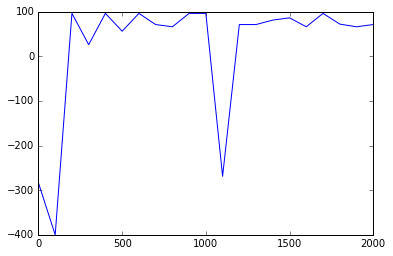

In [27]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,map(np.mean,rw))
    

In [28]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-02-22 05:14:37,176] Making new env: ppaquette/DoomBasic-v0
[2017-02-22 05:14:37,190] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 05:14:37,192] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-02-22 05:14:38,330] Starting new video recorder writing to /root/anet/agentnet/examples/records/openaigym.video.21.28576.video000000.mp4
[2017-02-22 05:14:38,933] Starting new video recorder writing to /root/anet/agentnet/examples/records/openaigym.video.21.28576.video000001.mp4


Episode finished after 1 timesteps with reward=96.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 6 timesteps with reward=71.0


[2017-02-22 05:14:39,821] Starting new video recorder writing to /root/anet/agentnet/examples/records/openaigym.video.21.28576.video000008.mp4


Episode finished after 3 timesteps with reward=86.0
Episode finished after 2 timesteps with reward=91.0
Episode finished after 2 timesteps with reward=91.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=76.0


[2017-02-22 05:14:41,253] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')


Episode finished after 6 timesteps with reward=71.0
Episode finished after 7 timesteps with reward=66.0
mean session score=82.000000.5


In [29]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"doombasic_dqn_2000.pcl")

In [30]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = filter(lambda s:s.endswith(".mp4"),os.listdir("./records/"))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets